In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
#from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import matplotlib


In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis
from polarity.dynamics import EllipsoidLameGeometry as geom
#from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom


In [4]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190712_one_fold_line_tension_homogene')

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [5]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

In [6]:
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension
model = model_factory(
    [
        RadialTension,
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [7]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0):

    h5store = '../examples/superegg_final.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    
    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)
    
    sheet = Sheet('spherical', datasets, specs)
    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_volume_elasticity'] = 3.e-6
    #sheet.settings['lumen_prefered_vol'] = sheet.settings['lumen_prefered_vol'] - sheet.settings['lumen_prefered_vol']*10/100

    sheet.edge_df['line_tension'] = 0
    
    return sheet

sheet = load_before_apopto(0)

geom.update_all(sheet)



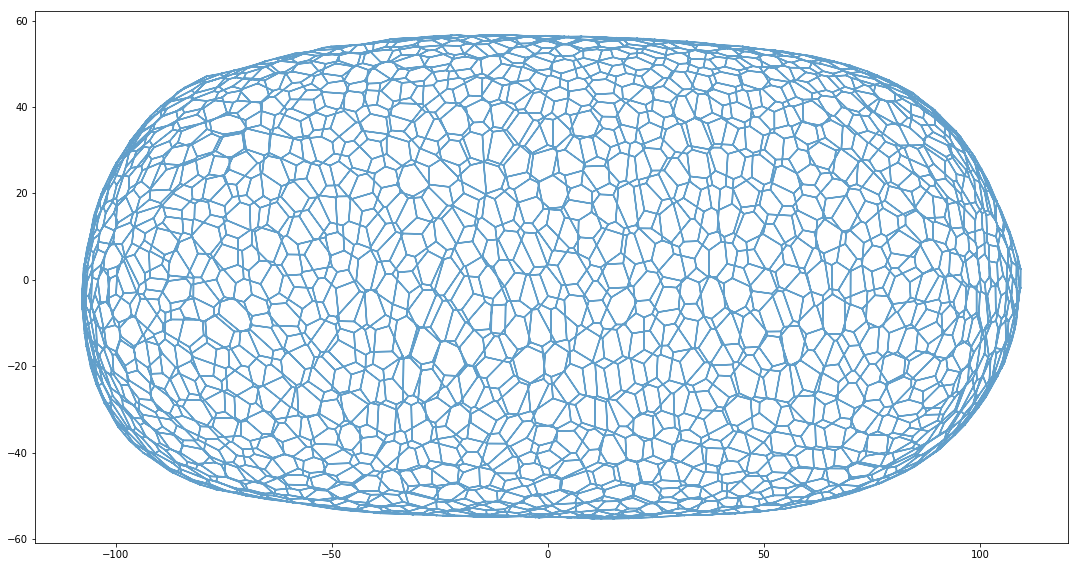

In [8]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)

fig.set_size_inches(18.5, 10.5, forward=True)

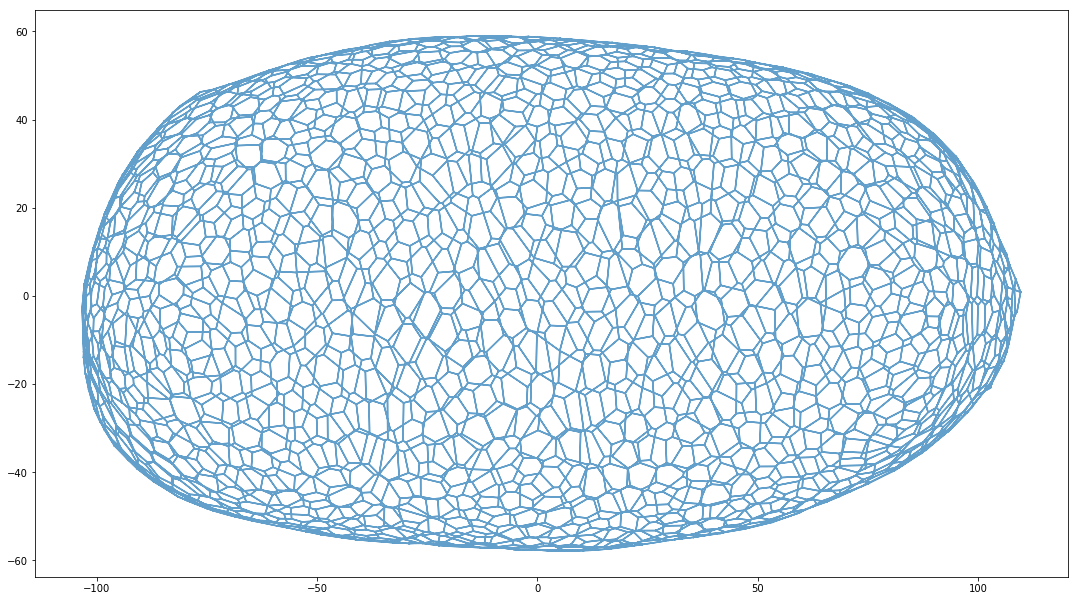

In [9]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
fig.set_size_inches(18.5, 10.5, forward=True)

In [10]:
"""import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig"""
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'white'},
                      face={'color':'black', 'visible':True})
fig



Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [11]:
def define_fold_position(sheet, fold_number = 2, position=[-36, -22, 22, 36]):
    #position = [min, max, min, max]
    sheet.face_df['fold'] = 0
    for i in range(fold_number):
        i=i*2
        sheet.face_df.loc[sheet.face_df[(sheet.face_df.z>position[i]) 
                                        & (sheet.face_df.z<position[i+1])].index, 'fold'] = i+1
        
        
        
define_fold_position(sheet, fold_number = 1, position=[-7, 7])
print(len(sheet.face_df[sheet.face_df.fold==1]))
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


113


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [12]:
def increase_linear_tension_lateral(sheet, face, line_tension):
    edges = sheet.edge_df[sheet.edge_df["face"] == face]
    for index, edge in edges.iterrows():
        angle_ = np.arctan2(
            sheet.edge_df.loc[edge.name, "dx"], sheet.edge_df.loc[edge.name, "dz"]
        )
        if ( ((np.abs(angle_) < np.pi/4) and (np.abs(angle_) > -np.pi/4)) or
            ((np.abs(angle_) > -np.pi/4) and (np.abs(angle_) < np.pi/4)) or
           ((np.abs(angle_) > 3*np.pi/4) and (np.abs(angle_) < 5*np.pi/4)) or
           ((np.abs(angle_) < -5*np.pi/4) and (np.abs(angle_) > -3*np.pi/4)) ):
        
            sheet.edge_df.loc[edge.name, "line_tension"] *=1
        else : 
            sheet.edge_df.loc[edge.name, "line_tension"] *= 30
            
def increase_linear_tension_dv(sheet, face, line_tension):
    edges = sheet.edge_df[sheet.edge_df["face"] == face]
    for index, edge in edges.iterrows():
        angle_ = np.arctan2(
            sheet.edge_df.loc[edge.name, "dy"], sheet.edge_df.loc[edge.name, "dz"]
        )
        if ( ((np.abs(angle_) < np.pi/4) and (np.abs(angle_) > -np.pi/4)) or
            ((np.abs(angle_) > -np.pi/4) and (np.abs(angle_) < np.pi/4)) or
           ((np.abs(angle_) > 3*np.pi/4) and (np.abs(angle_) < 5*np.pi/4)) or
           ((np.abs(angle_) < -5*np.pi/4) and (np.abs(angle_) > -3*np.pi/4)) ):
        
            sheet.edge_df.loc[edge.name, "line_tension"] *=1
        else : 
            sheet.edge_df.loc[edge.name, "line_tension"] *= 3
        

            
"""sheet.edge_df.line_tension=15
sheet.edge_df['id_']= sheet.edge_df.index

sheet2 = sheet.extract('fold')
sheet2 = sheet2.extract_bounding_box(y_boundary=(30,150))
[increase_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]
for i in (sheet2.edge_df.index):
    if sheet2.edge_df.loc[i, 'line_tension']!=15:
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=450
    
sheet2 = sheet.extract('fold')
sheet2 = sheet2.extract_bounding_box(y_boundary=(-150,-30))
[increase_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]
for i in (sheet2.edge_df.index):
    if sheet2.edge_df.loc[i, 'line_tension']!=15:
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=450

sheet2 = sheet.extract('fold')        
sheet2 = sheet2.extract_bounding_box(x_boundary=(-150,-30))
[increase_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]
for i in (sheet2.edge_df.index):
    if sheet2.edge_df.loc[i, 'line_tension']!=15:
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=450

sheet2 = sheet.extract('fold')
sheet2 = sheet2.extract_bounding_box(x_boundary=(30,150))
[increase_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]
for i in (sheet2.edge_df.index):
    if sheet2.edge_df.loc[i, 'line_tension']!=15:
        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=450

"""

"sheet.edge_df.line_tension=15\nsheet.edge_df['id_']= sheet.edge_df.index\n\nsheet2 = sheet.extract('fold')\nsheet2 = sheet2.extract_bounding_box(y_boundary=(30,150))\n[increase_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]\nfor i in (sheet2.edge_df.index):\n    if sheet2.edge_df.loc[i, 'line_tension']!=15:\n        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=450\n    \nsheet2 = sheet.extract('fold')\nsheet2 = sheet2.extract_bounding_box(y_boundary=(-150,-30))\n[increase_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]\nfor i in (sheet2.edge_df.index):\n    if sheet2.edge_df.loc[i, 'line_tension']!=15:\n        sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=450\n\nsheet2 = sheet.extract('fold')        \nsheet2 = sheet2.extract_bounding_box(x_boundary=(-150,-30))\n[increase_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]\nfor i 

In [13]:
sheet.face_df['apoptosis'] = 0


def apoptosis_ventral (sheet, code_fold = 1):
    
    fold_cell= sheet.face_df[sheet.face_df.fold == code_fold]
    
    for i in fold_cell.itertuples(): 
        proba = 0.6*np.exp(-(i.phi+3)**2/0.7**2) + 0.6*np.exp(-(i.phi-3)**2/0.7**2)
        aleatory_number = random.uniform(0,1)
        if aleatory_number < proba:
            sheet.face_df.loc[i.Index, "apoptosis"] = 1
        


apoptosis_ventral(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [14]:
def apoptosis_lateral (sheet, code_fold = 1):
    
    fold_cell= sheet.face_df[sheet.face_df.fold == code_fold]
    
    for i in fold_cell.itertuples(): 
        proba = 0.3*np.exp(-(i.phi+1.5)**2/0.8**2) + 0.3*np.exp(-(i.phi-1.5)**2/0.8**2)
        aleatory_number = random.uniform(0,1)
        if aleatory_number < proba:
            sheet.face_df.loc[i.Index, "apoptosis"] = 2
        


apoptosis_lateral(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [15]:
def apoptosis_dorsal (sheet, code_fold = 1):
    
    fold_cell= sheet.face_df[sheet.face_df.fold == code_fold]
    
    for i in fold_cell.itertuples(): 
        proba = 0.2*np.exp(-(i.phi)**2/0.4*2)
        aleatory_number = random.uniform(0,1)
        if aleatory_number < proba:
            sheet.face_df.loc[i.Index, "apoptosis"] = 3
        


apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [16]:
len(sheet.face_df[sheet.face_df.apoptosis>0])

37

In [17]:
len(sheet.face_df[sheet.face_df.fold>0])

113

In [18]:
len(sheet.face_df[sheet.face_df.apoptosis==1])

16

In [19]:
len(sheet.face_df[sheet.face_df.apoptosis==2])

19

In [20]:
len(sheet.face_df[sheet.face_df.apoptosis==3])

2

In [21]:
def run_sim(sim_save_dir, sheet, constriction, radial_tension, line_tension, iteration=0):
    
    dirname = '{}_constriction_{}_radialtension_{}_linetension_{}'.format(
        constriction,radial_tension, line_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    sheet.edge_df.line_tension = line_tension
    
    apoptosis_settings = {
        "critical_area": 5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":30,
        "current_traction":0,
        "geom": geom,
    }
    
    
    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    res = solver.find_energy_min(sheet2, geom, model, options={"gtol": 1e-8})


    sheet2 = apoptosis_process(dirname, solver, sheet2, geom, model)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [23]:
def apoptosis_process(dirname, solver, sheet, geom, model):
    
    # Initiate manager
    manager = EventManager('face')
    
    t = 0
    stop = 150
        
    # Run simulation
    while t < stop:
        if t%10 == 0:
            sheet.settings['lumen_prefered_vol'] *= 0.99        
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0
        
        # Add face in apoptosis according to the 
        # spatio-temporal patterning define previously
        if t == 1 :
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 1].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        if t == 11 : 
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 2].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
                
        if t == 21:
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 3].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
    
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        
        
        with pd.HDFStore(hdfname) as test:
            test.put("settings", pd.Series(sheet.settings))

        with pd.HDFStore(hdfname) as store:
            settings = store['settings']
        
        hdf5.save_datasets(hdfname, sheet)



        manager.update()
        t += 1

    return sheet


In [24]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()

radial_tension = [30]

contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]

line_tensions = [0,5,10,15,20,25]

contractility_rate, radial_tension, line_tension = np.meshgrid(contractility_rate, 
                                                               radial_tension,
                                                               line_tensions)

results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, sheet, c, rd, lt, 0) 
                             for c, rd, lt in zip(contractility_rate.ravel(),
                                              radial_tension.ravel(),
                                              line_tension.ravel()
                                             ))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-07-12 14:05:49.788434
end : 2019-07-12 21:55:38.053110
Duree totale d execution : 
		
7:49:48.264676
